In [9]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os, sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

In [10]:
%matplotlib inline

In [11]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.'

def download_progress_hook(count, block_size, total_size):
    global last_percent_report
    percent = int(count * block_size * 100 / total_size)
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent

    
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)


Found and verified ./notMNIST_large.tar.gz
Found and verified ./notMNIST_small.tar.gz


In [12]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
    root = os.path.splitext(os.path.splitext(filename)[0])[0] 
    if os.path.isdir(root) and not force:
        # You may override by setting force=True.
        print('%s already present - Skipping extraction of %s.' % (root, filename))
    else:
        print('Extracting data for %s. This may take a while. Please wait.' % root)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall(data_root)
        tar.close()
    data_folders = [
        os.path.join(root, d) for d in sorted(os.listdir(root))
            if os.path.isdir(os.path.join(root, d))]
    if len(data_folders) != num_classes:
        raise Exception('Expected %d folders, one per class. Found %d instead.' % (
                num_classes, len(data_folders)))
    print(data_folders)
    return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

./notMNIST_large already present - Skipping extraction of ./notMNIST_large.tar.gz.
['./notMNIST_large/A', './notMNIST_large/B', './notMNIST_large/C', './notMNIST_large/D', './notMNIST_large/E', './notMNIST_large/F', './notMNIST_large/G', './notMNIST_large/H', './notMNIST_large/I', './notMNIST_large/J']
./notMNIST_small already present - Skipping extraction of ./notMNIST_small.tar.gz.
['./notMNIST_small/A', './notMNIST_small/B', './notMNIST_small/C', './notMNIST_small/D', './notMNIST_small/E', './notMNIST_small/F', './notMNIST_small/G', './notMNIST_small/H', './notMNIST_small/I', './notMNIST_small/J']


In [13]:
# check data is right or not
Image(filename=os.path.join(train_folders[1], os.listdir(train_folders[1])[1]))


In [14]:
image_size = 28
pixel_depth = 255.0

def load_letter(folder, min_num_images):
    image_files = os.listdir(folder)
    dataset = np.ndarray(shape=(len(image_files), image_size, image_size), dtype=np.float32)
    
    print(folder)
    num_images = 0
    for image in image_files:
        image_file = os.path.join(folder, image)
        
        try:
            image_data = (ndimage.imread(image_file).astype(float) - pixel_depth / 2) / pixel_depth
            if image_data.shape != (image_size , image_size):
                raise Expection("Unexpected Image Shape %s" % str(image_data.shape))
            dataset[num_images, :, :] = image_data
            num_images += 1
        except IOError as e:
            print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    dataset = dataset[0:num_images, :, :]
    if num_images < min_num_images:
        raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
    print('Full dataset tensor:', dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset))
    return dataset
            
    

def maybe_pickle(data_folders, min_num_images_per_class, force=False):
    dataset_names = []
    for folder in data_folders:
        set_filename = folder + '.pickle'
        dataset_names.append(set_filename)
        if os.path.exists(set_filename) and not force:
        # You may override by setting force=True.
            print('%s already present - Skipping pickling.' % set_filename)
        else:
            print('Pickling %s.' % set_filename)
        dataset = load_letter(folder, min_num_images_per_class)
        try:
            with open(set_filename, 'wb') as f:
                pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
        except Exception as e:
            print('Unable to save data to', set_filename, ':', e)
    return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

./notMNIST_large/A.pickle already present - Skipping pickling.
./notMNIST_large/A
Could not read: ./notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png : cannot identify image file './notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png' - it's ok, skipping.
Could not read: ./notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png : cannot identify image file './notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png' - it's ok, skipping.
Could not read: ./notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png : cannot identify image file './notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png' - it's ok, skipping.
Full dataset tensor: (52909, 28, 28)
Mean: -0.12825
Standard deviation: 0.443121
./notMNIST_large/B.pickle already present - Skipping pickling.
./notMNIST_large/B
Could not read: ./notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png : cannot identify image file './notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png' - it's ok, skipping.
Full dataset tensor: (52911, 28, 28

[[-0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.49607843 -0.5        -0.36274511  0.31960785 -0.04117647 -0.46862745
  -0.5        -0.49215686 -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5       ]
 [-0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.49607843 -0.5        -0.04901961  0.5         0.5         0.2647059
  -0.32745099 -0.5        -0.48823529 -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5       ]
 [-0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5         0.35882354  0.19019608  0.17450981  0.5
   0.40196079 -0.30000001 -0.5        -0.48431373 -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5       ]
 [-0.5        -0.5        -0.5

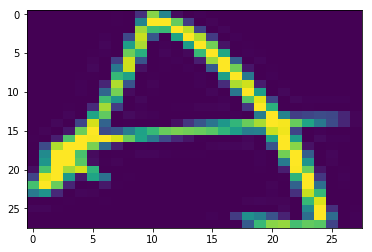

In [15]:
objects = []
testfile = train_folders[0] + ".pickle"
with (open(testfile, "rb")) as openfile:
    while True:
        try:
            objects.append(pickle.load(openfile))
        except EOFError:
            break
print(objects[0][0])
plt.imshow(objects[0][0],aspect="auto")
plt.show()


In [28]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


In [29]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

In [31]:
pickle_file = 'notMNIST.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise


In [32]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)


Compressed pickle size: 690800441


In [36]:
import time

def check_overlaps(images1, images2):
    images1.flags.writeable=False
    images2.flags.writeable=False
    start = time.clock()
    hash1 = set([hash(image1.data) for image1 in images1])
    hash2 = set([hash(image2.data) for image2 in images2])
    all_overlaps = set.intersection(hash1, hash2)
    return all_overlaps, time.clock()-start

r, execTime = check_overlaps(train_dataset, test_dataset)    
print('Number of overlaps between training and test sets: {}. Execution time: {}.'.format(len(r), execTime))

r, execTime = check_overlaps(train_dataset, valid_dataset)   
print('Number of overlaps between training and validation sets: {}. Execution time: {}.'.format(len(r), execTime))

r, execTime = check_overlaps(valid_dataset, test_dataset) 
print('Number of overlaps between validation and test sets: {}. Execution time: {}.'.format(len(r), execTime))


Number of overlaps between training and test sets: 1116. Execution time: 0.997915.
Number of overlaps between training and validation sets: 942. Execution time: 1.014494.
Number of overlaps between validation and test sets: 68. Execution time: 0.094108.


In [37]:
# Here you have 200000 samples
# 28 x 28 features
# We have to reshape them because scikit-learn expects (n_samples, n_features)
train_dataset.shape

(200000, 28, 28)

In [38]:
test_dataset.shape

(10000, 28, 28)

In [47]:
samples, width, height = train_dataset.shape
X_train = np.reshape(train_dataset,(samples,width*height))
y_train = train_labels

# Prepare testing data
samples, width, height = test_dataset.shape
X_test = np.reshape(test_dataset,(samples,width*height))
y_test = test_labels


In [48]:
# Import
from sklearn.linear_model import LogisticRegression

# Instantiate
lg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42, verbose=1, max_iter=1000, n_jobs=-1)

# Fit
lg.fit(X_train, y_train)

# Predict
y_pred = lg.predict(X_test)

# Score
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred)

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 11.5min finished


0.89629999999999999